In [32]:
import numpy as np
import random
import math
import random
import os
import sys

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

In [2]:
## Class with rule of marriage of community: Only with different community
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self,id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filho_disponivel, posição_filho, idade_filho = filho_e_idade(self, 1) #Se a unidade tem um filho homem disponivel para procurar esposa
        if filho_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, self.parentes[0:5] + self.parentes[7:9]) and # Que a UD não seja um parent
                    filho_e_idade(ud,0)[0] and #Que tenha uma filha
                    abs(filho_e_idade(ud,0)[2] - idade_filho) <= 13 and #Que a diferença entre as idades não seja maior a 10
                    ud.community != self.community] #From a different community 
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filha_disponivel, posição_filha, idade_filha = filho_e_idade(UD.uds[cassal_id], 0)
                #print(filha_disponivel, posição_filha, idade_filha)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                locality = True
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community )
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filho)
                self.uds[cassal_id].filhos.pop(posição_filha)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                #novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

In [35]:
## Class with rule of marriage of community: only with both the communities closer to the UDs one
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self,id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        
        def specific_community(comm): #Function to define the community of Ego´s partner
            return [(comm % 5) + 1, (comm - 2) % 5 + 1]
        
        def is_id_in_nested_lists(id_ud, nested_list): #Function to desentangle lists in the parents part
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        def filho_e_idade(self, sexo): #Function to facilitate the search for children according to sex and age
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filho_disponivel, posição_filho, idade_filho = filho_e_idade(self, 1) #Se a unidade tem um filho homem disponivel para procurar esposa
        if filho_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, self.parentes[0:5] + self.parentes[7:9]) and # Que a UD não seja um parent
                    filho_e_idade(ud,0)[0] and #Que tenha uma filha
                    abs(filho_e_idade(ud,0)[2] - idade_filho) <= 13 and #Que a diferença entre as idades não seja maior a 10
                    ud.community in specific_community(self.community)] #From a different community 
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filha_disponivel, posição_filha, idade_filha = filho_e_idade(UD.uds[cassal_id], 0)
                #print(filha_disponivel, posição_filha, idade_filha)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                locality = True
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community )
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filho)
                self.uds[cassal_id].filhos.pop(posição_filha)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                #novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

In [33]:
def specific_community(comm):
    return [(comm % 5) + 1, (comm - 2) % 5 + 1]

# Ejemplo de uso:
numero_ejemplo = 3
resultados = numeros_arriba_y_abajo(numero_ejemplo)
print(f"Para {numero_ejemplo}: Número superior: {resultados[0]}, Número inferior: {resultados[1]}")
print(resultados)


Para 3: Número superior: 4, Número inferior: 2
[4, 2]


In [27]:
print(2/5)
print(2%5)

0.4
2


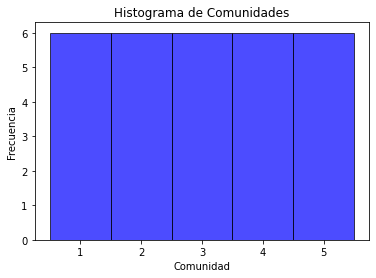

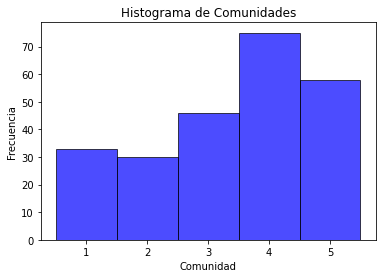

In [40]:
#### Parameters for simulation
n = 30 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
average_children = 4 # Average children per UD
random.seed(42) # Random seed
t = 500 #steps of the simulation
UD.uds = {}

#### Initialization
comunidades_disponibles = [i for i in range(1, 6) for _ in range(6)]
instancias_ud = []
for id_ud in range(1, n + 1):
    instancias_ud.append(UD(id_ud, average_children, comunidades_disponibles.pop(0)))

comunidades_lista = [ud.community for ud in UD.uds.values()]
# Get the first distribution of UDs for community
plt.hist(comunidades_lista, bins=range(1, 7), align='left', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma de Comunidades')
plt.xlabel('Comunidad')
plt.ylabel('Frecuencia')
plt.show()
    
#### Simulation
for i in range (1, (t)):
    uds_copy = dict(UD.uds) #As UDs existentes no tempo n
    any_ud_active = False # Flag to see if the simulation went to extintion
    for id_ud, ud in uds_copy.items():
        if ud.activa == True:
            any_ud_active = True
            ud.ter_filho()
            ud.buscar_ud(average_children, 50)
            ud.incrementar_idade()
            ud.death_probability(prob_morte)
comunidades_lista = [ud.community for ud in UD.uds.values()]
# Final distribution of UDs for community
plt.hist(comunidades_lista, bins=range(1, 7), align='left', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma de Comunidades')
plt.xlabel('Comunidad')
plt.ylabel('Frecuencia')
plt.show()

In [24]:
# Verificar la asignación de comunidades
for id, ud in UD.uds.items():
    print(f"UD {ud.id} - Community: {ud.community}")

UD 1 - Community: 1
UD 2 - Community: 1
UD 3 - Community: 1
UD 4 - Community: 1
UD 5 - Community: 1
UD 6 - Community: 1
UD 7 - Community: 2
UD 8 - Community: 2
UD 9 - Community: 2
UD 10 - Community: 2
UD 11 - Community: 2
UD 12 - Community: 2
UD 13 - Community: 3
UD 14 - Community: 3
UD 15 - Community: 3
UD 16 - Community: 3
UD 17 - Community: 3
UD 18 - Community: 3
UD 19 - Community: 4
UD 20 - Community: 4
UD 21 - Community: 4
UD 22 - Community: 4
UD 23 - Community: 4
UD 24 - Community: 4
UD 25 - Community: 5
UD 26 - Community: 5
UD 27 - Community: 5
UD 28 - Community: 5
UD 29 - Community: 5
UD 30 - Community: 5
UD 31 - Community: 4
UD 32 - Community: 1
UD 33 - Community: 2
UD 34 - Community: 3
UD 35 - Community: 3
UD 36 - Community: 3
UD 37 - Community: 3
UD 38 - Community: 5
UD 39 - Community: 2
UD 40 - Community: 4
UD 41 - Community: 2
UD 42 - Community: 1
UD 43 - Community: 5
UD 44 - Community: 4
UD 45 - Community: 5
UD 46 - Community: 2
UD 47 - Community: 2
UD 48 - Community: 4
U

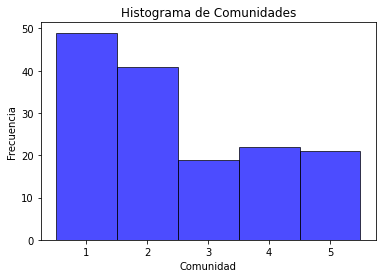

In [37]:
comunidades_lista = [ud.community for ud in UD.uds.values()]
# Crear un histograma
plt.hist(comunidades_lista, bins=range(1, 7), align='left', alpha=0.7, color='blue', edgecolor='black')

# Configurar el título y las etiquetas de los ejes
plt.title('Histograma de Comunidades')
plt.xlabel('Comunidad')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [ ]:
#Unidades
print(len(UD.uds))

# for id, nodo in UD.uds.items():
#     #print(nodo.id)
#     print(f"""
#     ID : {nodo.id},  
#     Estado = {nodo.activa}
#     Pai: {nodo.parentes[0]},    
#     Mãe: {nodo.parentes[1]}
#     Filhos (nós): {nodo.parentes[2]},    
#     Avos: {nodo.parentes[3]},    
#     Irmãos:{nodo.parentes[4]}
#     Tios:{nodo.parentes[5]},    
#     Primos: {nodo.parentes[6]},    
#     Netos: {nodo.parentes[7]}
#     Sobrinhos: {nodo.parentes[8]}
#     Filhos disponiveis: {nodo.filhos}
#     Cassais pasados: {nodo.parentes[9]}
#     Idade: {nodo.age}
#     """)

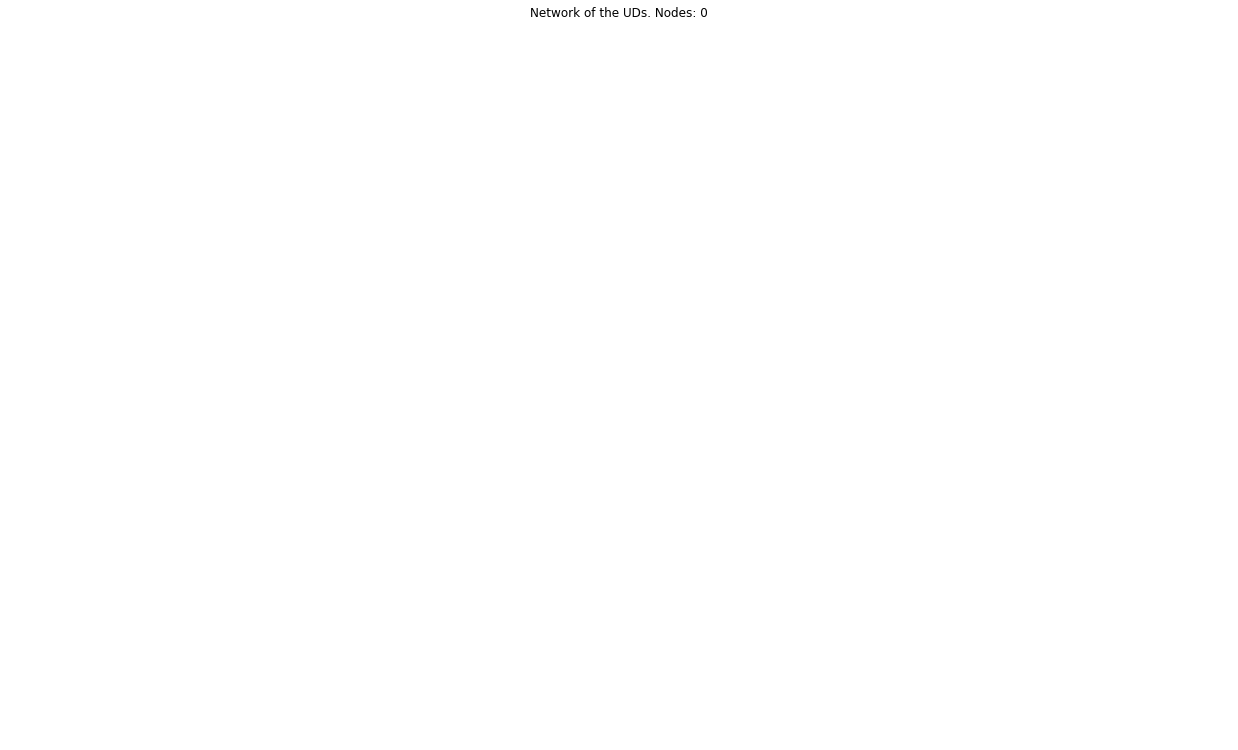

----------------------------


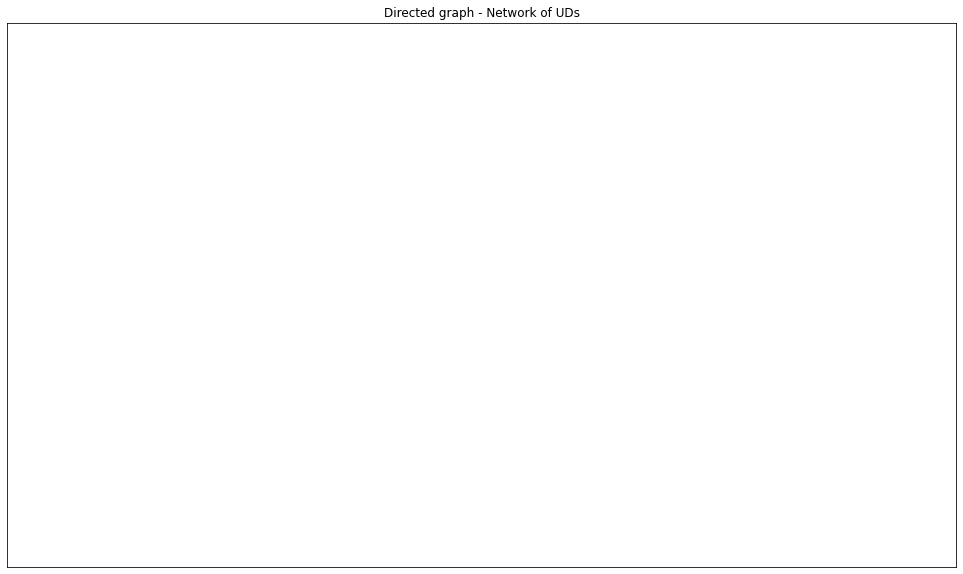

In [41]:
create_vis_geral(UD.uds, False)
p_graph(UD.uds, False)

In [8]:
#### Parameters for simulation
n = 30 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
average_children = 4 # Average children per UD
random.seed(42) # Random seed
t = 200 #steps of the simulation
# Crear una lista con números del 1 al 5 repetidos 6 veces
comunidades_disponibles = [i for i in range(1, 6) for _ in range(6)]

# Número total de objetos UD que quieres crear
UD.uds = {}
instancias_ud = []

# Crear instancias UD asignando cada UD a una comunidad y eliminando de la lista
for id_ud in range(1, n + 1):
    community = comunidades_disponibles.pop(0)  # Tomar el primer elemento de la lista
    instancias_ud.append(UD(id_ud, average_children, community))

# Verificar la asignación de comunidades
for ud in instancias_ud:
    print(f"UD {ud.id} - Community: {ud.community}")

UD 1 - Community: 1
UD 2 - Community: 1
UD 3 - Community: 1
UD 4 - Community: 1
UD 5 - Community: 1
UD 6 - Community: 1
UD 7 - Community: 2
UD 8 - Community: 2
UD 9 - Community: 2
UD 10 - Community: 2
UD 11 - Community: 2
UD 12 - Community: 2
UD 13 - Community: 3
UD 14 - Community: 3
UD 15 - Community: 3
UD 16 - Community: 3
UD 17 - Community: 3
UD 18 - Community: 3
UD 19 - Community: 4
UD 20 - Community: 4
UD 21 - Community: 4
UD 22 - Community: 4
UD 23 - Community: 4
UD 24 - Community: 4
UD 25 - Community: 5
UD 26 - Community: 5
UD 27 - Community: 5
UD 28 - Community: 5
UD 29 - Community: 5
UD 30 - Community: 5


In [67]:
for i in range(1, 31):
    print(UD.uds[i].id)
    print(UD.uds[i].community)
#print(UD.uds[10].community)

1
5
2
5
3
5
4
5
5
5
6
5
7
5
8
5
9
5
10
5
11
5
12
5
13
5
14
5
15
5
16
5
17
5
18
5
19
5
20
5
21
5
22
5
23
5
24
5
25
5
26
5
27
5
28
5
29
5
30
5


In [68]:
print(instancias_ud[11].community)
print(UD.uds[11].community)

2
5


In [54]:
UD.uds[1].id

1

In [31]:
comunidades

[1, 2, 3, 4, 5]